In [1]:
import json
import nltk
from nltk.tokenize import RegexpTokenizer
import string
import math
import os
import time
from collections import namedtuple
import cPickle as pickle
import pandas as pd

import pyspark
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.classification import SVMWithSGD, SVMModel

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import random
from sklearn.metrics import coverage_error
import sklearn.metrics
from gensim.models.doc2vec import Doc2Vec, LabeledSentence
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
import logging
from logging import info
from functools import partial

In [2]:
root = logging.getLogger()
for handler in root.handlers[:]:
    root.removeHandler(handler)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) # adds a default StreamHanlder
#root.addHandler(logging.StreamHandler())

In [3]:
IS_SAMPLE = True

In [4]:
SVM_SEED = 1234
DOC2VEC_SEED = 1234

In [4]:
NUMBER_INDICATOR = "number_inidicator"
CURRENCY_INDICATOR = "currency_inidicator"
CHEMICAL_INDICATOR = "chemical_inidicator"
MIN_WORD_COUNT = 5
MIN_SIZE = 0
NUM_CORES = 20

In [8]:
GLOBAL_VARS = namedtuple('GLOBAL_VARS', ['MODEL_NAME', 'DOC2VEC_MODEL', 'SVM_MODEL_NAME'])

In [8]:
SAMPLE_RATIO = 0.0001

In [9]:
VOCAB_MODEL = "vocab_model"
MODEL_PREFIX = "model"
VALIDATION_MATRIX = "validation_matrix.pkl"
METRICS = "metrics.pkl"

In [10]:
#training_file = "/home/local/shalaby/docs_output_sample_100.json"

save_parent_location = "hdfs://deka.cip.ifi.lmu.de/pg-vectors/"
if IS_SAMPLE: 
    save_parent_location = save_parent_location + "sample_" + str(SAMPLE_RATIO) + "/"


root_location = "/big/s/shalaby/"
exports_location = root_location + "exported_data/"

doc2vec_model_save_location = os.path.join(root_location, "parameter_search_doc2vec_models", "sample_" + str(SAMPLE_RATIO))
if not os.path.exists(doc2vec_model_save_location):
    os.makedirs(doc2vec_model_save_location)
if not os.path.exists(os.path.join(doc2vec_model_save_location, VOCAB_MODEL)):
    os.makedirs(os.path.join(doc2vec_model_save_location, VOCAB_MODEL))

#training_file = root_location + "docs_output.json"
training_file = root_location + 'docs_output_training_validation_documents_' + str(SAMPLE_RATIO)

doc_classifications_map_file = exports_location + "doc_classification_map.pkl"
sections_file = exports_location + "sections.pkl"
classes_file = exports_location + "classes.pkl"
subclasses_file = exports_location + "subclasses.pkl"
classifications_output = exports_location + "classifications.pkl"
training_docs_list_file = exports_location + "training_documents_" + str(SAMPLE_RATIO) + "_sample.pkl"
validation_docs_list_file = exports_location + "validation_documents_" + str(SAMPLE_RATIO) + "_sample.pkl"

In [11]:
%%time
doc_classification_map = pickle.load(open(doc_classifications_map_file))
sections = pickle.load(open(sections_file))
classes = pickle.load(open(classes_file))
subclasses = pickle.load(open(subclasses_file))
training_docs_list = pickle.load(open(training_docs_list_file))
validation_docs_list = pickle.load(open(validation_docs_list_file))

CPU times: user 25.9 s, sys: 872 ms, total: 26.8 s
Wall time: 27.6 s


In [12]:
len(training_docs_list)

8979

In [13]:
len(validation_docs_list)

1969

In [14]:
def stemtokenizer(text):
    """ MAIN FUNCTION to get clean stems out of a text. A list of clean stems are returned """
    tokenizer = RegexpTokenizer(r'\s+', gaps=True)
    tokens = tokenizer.tokenize(text)
    stems = []  # result
    for token in tokens:
        stem = token.lower()
        stem = stem.strip(string.punctuation)
        if stem:
            if is_number(stem):
                stem = NUMBER_INDICATOR
            elif is_currency(stem):
                stem = CURRENCY_INDICATOR
            elif is_chemical(stem):
                stem = CHEMICAL_INDICATOR
            else:
                stem = stem.strip(string.punctuation)
            if stem and len(stem) >= MIN_SIZE:
                # extract uni-grams
                stems.append(stem)
    del tokens
    return stems

def is_number(str):
    """ Returns true if given string is a number (float or int)"""
    try:
        float(str.replace(",", ""))
        return True
    except ValueError:
        return False

def is_currency(str):
    return str[0] == "$"

def is_chemical(str):
    return str.count("-") > 3

In [15]:
def get_training_vector(classification, term_list, classifications, number_of_terms):
    clss = 1 if classification in classifications else 0
    return LabeledPoint(clss, SparseVector(number_of_terms, term_list))

def train_level_new(docs_index, classification, doc_classification_map, number_of_terms):
    training_vectors = docs_index.map(
        lambda (doc_id, postings): get_training_vector(classification, postings,
                                                        doc_classification_map[doc_id], number_of_terms))
    svm = SVMWithSGD.train(training_vectors, iterations=SVM_ITERATIONS, convergenceTol=SVM_CONVERGENCE, regParam=SVM_REG)
    return training_vectors, svm

get_binary = lambda x: 1 if x > 0 else 0
get_binary = np.vectorize(get_binary)


def get_row_top_N(y_score_row, y_true_row):
    desc_score_indices = np.argsort(y_score_row)[::-1]
    # print y_score_row
    # print y_true_row
    true_indices = np.where(y_true_row ==1)[0]
    # print desc_score_indices
    found = 0
    top_N = 0
    for i, score in enumerate(desc_score_indices):
        if score in true_indices:
            found += 1
            if found == len(true_indices):
                top_N = i + 1
    # print top_N
    return top_N


def get_metrics(y_true, y_score, y_binary_score):
    metrics = {}
    metrics['total_positive'] = np.sum(np.sum(y_binary_score))
    #TODO remove those two when running on the whole set to avoid excessive storage costs
    metrics['y_true'] = y_true
    metrics['y_score'] = y_score
    metrics['y_binary_score'] = y_binary_score
    metrics['coverage_error'] = coverage_error(y_true, y_binary_score)
    metrics['average_num_of_labels'] = np.sum(np.sum(y_true, axis=1))/y_true.shape[0]
    metrics['average_precision_micro'] = sklearn.metrics.average_precision_score(y_true, y_binary_score, average='micro')
    metrics['average_precision_macro'] = sklearn.metrics.average_precision_score(y_true, y_binary_score, average='macro')
    metrics['precision_micro'] = sklearn.metrics.precision_score(y_true, y_binary_score, average='micro')
    metrics['precision_macro'] = sklearn.metrics.precision_score(y_true, y_binary_score, average='macro')
    metrics['recall_micro'] = sklearn.metrics.recall_score(y_true, y_binary_score, average='micro')
    metrics['recall_macro'] = sklearn.metrics.recall_score(y_true, y_binary_score, average='macro')
    metrics['f1_micro'] = sklearn.metrics.f1_score(y_true, y_binary_score, average='micro')
    metrics['f1_macro'] = sklearn.metrics.f1_score(y_true, y_binary_score, average='macro')

    precision_scores = np.zeros(y_true.shape[1])
    for i in range(0, y_true.shape[1]):
        precision_scores[i] = sklearn.metrics.precision_score(y_true[:,i], y_binary_score[:,i])
    metrics['precision_scores_array'] = precision_scores.tolist()

    recall_scores = np.zeros(y_true.shape[1])
    for i in range(0, y_true.shape[1]):
        recall_scores[i] = sklearn.metrics.recall_score(y_true[:,i], y_binary_score[:,i])
    metrics['recall_scores_array'] = recall_scores.tolist()

    f1_scores = np.zeros(y_true.shape[1])
    for i in range(0, y_true.shape[1]):
        f1_scores[i] = sklearn.metrics.f1_score(y_true[:,i], y_binary_score[:,i])
    metrics['f1_scores_array'] = f1_scores.tolist()

    tops = []
    for i in xrange(y_score.shape[0]):
        tops.append(get_row_top_N(y_score[i,:], y_true[i,:]))
    metrics['topN_list'] = np.array(tops).tolist()
    metrics['topN_avg'] = np.mean(tops)
    
    return metrics

def model_exists(path):
    try:
        model = SVMModel.load(sc, path)
        return True;
    except:
        return False
    
def get_training_vector(classification, dense_vector, classifications):
    clss = 1 if classification in classifications else 0
    return LabeledPoint(clss, dense_vector)

def train_level_doc2vec(classification, doc_classification_map):
    doc2vec_model = GLOBAL_VARS.DOC2VEC_MODEL
    training_vectors = []
    for doc_id in training_docs_list:
        # converting from memmap to a normal array as spark is unable to convert memmap to a spark Vector
        normal_array = []
        normal_array[:] = doc2vec_model.docvecs[doc_id][:]
        training_vectors.append(get_training_vector(classification, normal_array, 
                                                    doc_classification_map[doc_id]))
    info("Finished getting training vectors")
    training_vectors = sc.parallelize(training_vectors)
    #info("Finished parallelization")
    svm = SVMWithSGD.train(training_vectors, iterations=SVM_ITERATIONS, convergenceTol=SVM_CONVERGENCE, regParam=SVM_REG)
    return training_vectors, svm

In [16]:
def ensure_hdfs_location_exists(location):
    parent = os.path.dirname(location)
    os.system("hdfs dfs -mkdir -p " + location)

def ensure_disk_location_exists(location):
    if not os.path.exists(location):
        os.makedirs(location)

def get_svm_model_path(method, classification, reg=SVM_REG, iterations=SVM_ITERATIONS):
    location = os.path.join(save_parent_location, "models", method, 
                            "iter_" + str(iterations) + "_reg_" + str(reg),
                            classification + "_model.svm")
    ensure_hdfs_location_exists(location)
    return location

def get_data_output_name(method, data_type="training"):
    location = os.path.join(save_parent_location, "models", method, 
                            data_type + "_data", 
                            "data.json")
    ensure_hdfs_location_exists(location)
    return location

def get_data_classification_output_name(method, classification, data_type="training"):
    location = os.path.join(save_parent_location, "models", method, 
                            data_type + "_data", 
                            classification + "_data.json")
    ensure_hdfs_location_exists(location)
    return location

def get_prediction_output_name(method, data_type="training", subset="sections", reg=SVM_REG, iterations=SVM_ITERATIONS):
    location = os.path.join(save_parent_location, "models", method,
                            "iter_" + str(iterations) + "_reg_" + str(reg),
                            data_type + "_" + subset + "_predictions.svm")
    ensure_hdfs_location_exists(location)
    return location
    
def get_labels_output_name(data_type="training", subset="sections", reg=SVM_REG, iterations=SVM_ITERATIONS):
    location = os.path.join(save_parent_location, "models", 
                            data_type + "_" + subset + "_labels.svm")
    ensure_hdfs_location_exists(location)
    return location

def get_metrics_output_name(method, data_type="training", subset="sections", reg=SVM_REG, iterations=SVM_ITERATIONS):
    location = os.path.join(save_parent_location, "models", method, 
                            "iter_" + str(iterations) + "_reg_" + str(reg),
                            data_type + "_" + subset + "_metrics.pkl")
    ensure_hdfs_location_exists(location)
    return location    
                            
def get_save_location(location, sample=False):
    if sample:
        return location.replace(save_parent_location, sample_save_parent_location)
    return location

In [17]:
def train_classifications(classifications):
    info("====== Doing Training")
    i=0
    for classification in classifications:
        print classification
        try:
            svm_model_path = get_svm_model_path(GLOBAL_VARS.MODEL_NAME, classification)
            if not model_exists(svm_model_path):
                training_vectors, svm = train_level_doc2vec(classification, doc_classification_map)
                logging.info("Saving to {}".format(svm_model_path))
                svm.save(sc, svm_model_path)
            else:
                print "Model Exists"
        except:
            print "Problem creating: %s: %s" % (classification, GLOBAL_VARS.MODEL_NAME)
            raise

In [18]:
def do_validation(validation_vectors_matrix, doc_classification_map, classifications, classifications_name):

    info("====== Doing Validation")
    method = GLOBAL_VARS.MODEL_NAME
    subset = classifications_name

    doc_count = validation_vectors_matrix.shape[0]
    y_score = np.zeros((doc_count, len(classifications)))
    y_true = np.zeros((doc_count, len(classifications)))
    i=0

    for classification in classifications:
        print classification

        validation_vectors = get_validation_doc2vec_spark_vectors(validation_vectors_matrix, 
                                                                  classification, doc_classification_map)
        #global binarySvm
        binarySvm = SVMModel.load(sc, get_svm_model_path(GLOBAL_VARS.MODEL_NAME, classification))
        info("Loaded the model, Doing the prediction now....")
        binarySvm.clearThreshold()
        binarySvmB = sc.broadcast(binarySvm)
        # using the broadcasted binarySvm variable, fixes global name 'binarySvm' is not defined as this variable was not
        # available in the workers, so we pass it explicitly to the mapper using partial
        labels_predictions = validation_vectors.map( \
            partial(lambda svm, p: (p.label, svm.value.predict(p.features)), binarySvmB) \
        ).collect()
        #labels = test_labeled_points.map(lambda p: p.labels)
        y_true[:,i] = [label_pred[0] for label_pred in labels_predictions]
        y_score[:,i] = [label_pred[1] for label_pred in labels_predictions]
        i+=1
    y_binary_score = get_binary(y_score)
    # results[method]["y_true"] = y_true
    # results[method]["y_score"] = y_score
    # results[method]["y_binary_score"] = y_binary_score
    metrics = get_metrics(y_true, y_score, y_binary_score)
    return metrics


In [19]:
def get_validation_docs_with_inference(doc2vec_model, doc_classification_map):
    """
    Use the trained doc2vec model to get the paragraph vector representations of the validation documents
    """
    if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)):
        validation_vectors_matrix = pickle.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)))
    else:
        validation_documents_reps = {}
        validation_vectors = []
        validation_labels = []
        info("===== Getting validation vectors with inference")

        # do inference and store results in dict
        i = 0
        for (doc_id, doc_contents_array) in ValidationDocumentGenerator(training_file, validation_docs_list):
            i += 1
            if i % 1000 == 0: info(str(i))
            validation_documents_reps[doc_id] = doc2vec_model.infer_vector(doc_contents_array)

        # create matrix for the validation vectors
        for validation_doc_id in validation_docs_list:
            validation_vectors.append(validation_documents_reps[validation_doc_id])
            validation_labels.append([classf for classf in doc_classification_map[validation_doc_id] if classf in sections])
        validation_vectors_matrix = np.array(validation_vectors)
        pickle.dump(validation_vectors_matrix, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX), 'w'))
    
    return validation_vectors_matrix

In [20]:
def get_validation_doc2vec_spark_vectors(validation_vectors_matrix, classification, doc_classification_map):
    validation_vectors = []
    for (index, doc_id) in enumerate(validation_docs_list):
        # converting from memmap to a normal array as spark is unable to convert memmap to a spark Vector
        validation_vector = validation_vectors_matrix[index]
        validation_vectors.append(get_training_vector(classification, validation_vector, 
                                                    doc_classification_map[doc_id]))
    validation_vectors = sc.parallelize(validation_vectors)
    info("Finished getting validation vectors")
    return validation_vectors

### Doc2vec and SVM Parameters

In [39]:
DOC2VEC_SIZE = 400
DOC2VEC_WINDOW = 8
DOC2VEC_MAX_VOCAB_SIZE = None
DOC2VEC_SAMPLE = 1e-5
DOC2VEC_TYPE = 1
DOC2VEC_HIERARCHICAL_SAMPLE = 0
DOC2VEC_NEGATIVE_SAMPLE_SIZE = 10
DOC2VEC_CONCAT = 1
DOC2VEC_MEAN = 0
DOC2VEC_TRAIN_WORDS = 0
DOC2VEC_EPOCHS = 1 # we do our training manually one epoch at a time
DOC2VEC_MAX_EPOCHS = 30
REPORT_DELAY = 60 # report the progress every x seconds
REPORT_VOCAB_PROGRESS = 1000 # report the progress every x terms

In [29]:
SVM_ITERATIONS = 1000
SVM_CONVERGENCE = 0.001
SVM_REG = 0.1
GLOBAL_VARS.SVM_MODEL_NAME = 'iter_{}_reg_{}'.format(SVM_ITERATIONS, SVM_REG)

In [30]:
class TrainingDocumentGenerator(object):
    def __init__(self, filename, training_docs_list):
        self.filename = filename
        self.training_docs_list = training_docs_list
    def __iter__(self):
        for line in open(self.filename):
            if not line.strip(): continue
            (doc_id, text) = eval(line)
            if doc_id in self.training_docs_list:
                yield LabeledSentence(words=stemtokenizer(text), tags=[doc_id])
                
class ValidationDocumentGenerator(object):
    def __init__(self, filename, validation_docs_list):
        self.filename = filename
        self.validation_docs_list = validation_docs_list
    def __iter__(self):
        for line in open(self.filename):
            if not line.strip(): continue
            (doc_id, text) = eval(line)
            if doc_id in self.validation_docs_list:
                yield doc_id, stemtokenizer(text)

## Create the Doc2vec model

In [31]:
placeholder_model_name = 'doc2vec_size_{}_w_{}_type_{}_concat_{}_mean_{}_trainwords_{}_hs_{}_neg_{}_vocabsize_{}'.format(DOC2VEC_SIZE, 
                                                                DOC2VEC_WINDOW, 
                                                                'dm' if DOC2VEC_TYPE == 1 else 'pv-dbow',
                                                                DOC2VEC_CONCAT, DOC2VEC_MEAN,
                                                                DOC2VEC_TRAIN_WORDS,
                                                                DOC2VEC_HIERARCHICAL_SAMPLE,DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                                                                str(DOC2VEC_MAX_VOCAB_SIZE))
placeholder_model_name = placeholder_model_name + "_curriter_{}"
placeholder_model_name

'doc2vec_size_400_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_{}'

In [32]:
doc2vec_model = Doc2Vec(size=DOC2VEC_SIZE , window=DOC2VEC_WINDOW, min_count=MIN_WORD_COUNT, 
                max_vocab_size= DOC2VEC_MAX_VOCAB_SIZE,
                sample=DOC2VEC_SAMPLE, seed=DOC2VEC_SEED, workers=NUM_CORES,
                # doc2vec algorithm dm=1 => PV-DM, dm=2 => PV-DBOW, PV-DM dictates CBOW for words
                dm=DOC2VEC_TYPE,
                # hs=0 => negative sampling, hs=1 => hierarchical softmax
                hs=DOC2VEC_HIERARCHICAL_SAMPLE, negative=DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                dm_concat=DOC2VEC_CONCAT,
                # would train words with skip-gram on top of cbow, we don't need that for now
                dbow_words=DOC2VEC_TRAIN_WORDS,
                iter=DOC2VEC_EPOCHS)

GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model

In [33]:
%%time
if not os.path.exists(os.path.join(doc2vec_model_save_location, VOCAB_MODEL, MODEL_PREFIX)):
    doc2vec_model.build_vocab(sentences=TrainingDocumentGenerator(training_file, training_docs_list), progress_per=REPORT_VOCAB_PROGRESS)
    doc2vec_model.save(os.path.join(doc2vec_model_save_location, VOCAB_MODEL, MODEL_PREFIX))
else: 
    doc2vec_model_vocab_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, VOCAB_MODEL, MODEL_PREFIX))
    doc2vec_model.reset_from(doc2vec_model_vocab_model)

2016-09-17 03:02:39,243 : INFO : loading Doc2Vec object from /big/s/shalaby/parameter_search_doc2vec_models/sample_0.0001/vocab_model/model
2016-09-17 03:02:39,843 : INFO : loading docvecs recursively from /big/s/shalaby/parameter_search_doc2vec_models/sample_0.0001/vocab_model/model.docvecs.* with mmap=None
2016-09-17 03:02:39,845 : INFO : loading syn1neg from /big/s/shalaby/parameter_search_doc2vec_models/sample_0.0001/vocab_model/model.syn1neg.npy with mmap=None
2016-09-17 03:02:42,683 : INFO : loading syn0 from /big/s/shalaby/parameter_search_doc2vec_models/sample_0.0001/vocab_model/model.syn0.npy with mmap=None
2016-09-17 03:02:42,849 : INFO : setting ignored attribute syn0norm to None
2016-09-17 03:02:42,850 : INFO : setting ignored attribute cum_table to None
2016-09-17 03:02:43,275 : INFO : using concatenative 6800-dimensional layer1
2016-09-17 03:02:43,276 : INFO : resetting layer weights


CPU times: user 4.58 s, sys: 3.21 s, total: 7.78 s
Wall time: 7.75 s


In [34]:
doc2vec_model.min_alpha = 0.025
epoch_metrics = []

In [ ]:
%%time
start_from = 21
for epoch in range(start_from, DOC2VEC_MAX_EPOCHS+1):
    GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
    info("****************** Epoch {} --- Working on {} *******************".format(epoch, GLOBAL_VARS.MODEL_NAME))
    
    # if we have the model, just load it, otherwise train the previous model
    if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)):
        doc2vec_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
        GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model
    else:
        # train the doc2vec model
        doc2vec_model.train(sentences=TrainingDocumentGenerator(training_file, training_docs_list), report_delay=REPORT_DELAY)
        doc2vec_model.alpha -= 0.001  # decrease the learning rate
        doc2vec_model.min_alpha = doc2vec_model.alpha  # fix the learning rate, no decay
        ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME))
        doc2vec_model.save(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
        GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model

    # Training and validation of SVMs using those docvecs
    train_classifications(sections)
    validation_vectors_matrix = get_validation_docs_with_inference(doc2vec_model, doc_classification_map)
    metrics = do_validation(validation_vectors_matrix, doc_classification_map, sections, "sections")
    ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                             GLOBAL_VARS.SVM_MODEL_NAME))
    pickle.dump(metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, GLOBAL_VARS.SVM_MODEL_NAME, METRICS), 'w'))
    add_metrics_to_graph(metrics)
    print "Coverage Error: {}, Average No of Labels: {}, Top N: {}, F1 Micro: {}, Total Positive: {}".format(
        metrics['coverage_error'], metrics['average_num_of_labels'], metrics['topN_avg'], metrics['f1_micro'], 
        metrics['total_positive'])
                                                                                         
    epoch_metrics.append(metrics)


2016-09-17 18:30:02,334 : INFO : ****************** Epoch 21 --- Working on doc2vec_size_400_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_21 *******************
2016-09-17 18:30:02,337 : INFO : loading Doc2Vec object from /big/s/shalaby/parameter_search_doc2vec_models/sample_0.0001/doc2vec_size_400_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_21/model
2016-09-17 18:30:02,926 : INFO : loading docvecs recursively from /big/s/shalaby/parameter_search_doc2vec_models/sample_0.0001/doc2vec_size_400_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_21/model.docvecs.* with mmap=None
2016-09-17 18:30:02,927 : INFO : loading syn1neg from /big/s/shalaby/parameter_search_doc2vec_models/sample_0.0001/doc2vec_size_400_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_21/model.syn1neg.npy with mmap=None
2016-09-17 18:30:04,321 : INFO : loading syn0 from /big/s/shalaby/parameter_search

A


2016-09-17 18:30:10,545 : INFO : Finished getting training vectors
2016-09-17 18:30:39,232 : INFO : Saving to hdfs://deka.cip.ifi.lmu.de/pg-vectors/sample_0.0001/models/doc2vec_size_400_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_21/iter_1000_reg_0.1/A_model.svm


B


2016-09-17 18:30:44,609 : INFO : Finished getting training vectors
2016-09-17 18:31:13,889 : INFO : Saving to hdfs://deka.cip.ifi.lmu.de/pg-vectors/sample_0.0001/models/doc2vec_size_400_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_21/iter_1000_reg_0.1/B_model.svm


C


2016-09-17 18:31:19,276 : INFO : Finished getting training vectors
2016-09-17 18:31:45,073 : INFO : Saving to hdfs://deka.cip.ifi.lmu.de/pg-vectors/sample_0.0001/models/doc2vec_size_400_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_21/iter_1000_reg_0.1/C_model.svm


D


2016-09-17 18:31:50,612 : INFO : Finished getting training vectors
2016-09-17 18:32:30,552 : INFO : Saving to hdfs://deka.cip.ifi.lmu.de/pg-vectors/sample_0.0001/models/doc2vec_size_400_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_21/iter_1000_reg_0.1/D_model.svm


E


2016-09-17 18:32:36,593 : INFO : Finished getting training vectors
2016-09-17 18:33:09,050 : INFO : Saving to hdfs://deka.cip.ifi.lmu.de/pg-vectors/sample_0.0001/models/doc2vec_size_400_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_21/iter_1000_reg_0.1/E_model.svm


F


2016-09-17 18:33:14,123 : INFO : Finished getting training vectors
2016-09-17 18:33:42,094 : INFO : Saving to hdfs://deka.cip.ifi.lmu.de/pg-vectors/sample_0.0001/models/doc2vec_size_400_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_21/iter_1000_reg_0.1/F_model.svm


G


2016-09-17 18:33:48,462 : INFO : Finished getting training vectors
2016-09-17 18:34:12,056 : INFO : Saving to hdfs://deka.cip.ifi.lmu.de/pg-vectors/sample_0.0001/models/doc2vec_size_400_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_21/iter_1000_reg_0.1/G_model.svm


H


2016-09-17 18:34:17,420 : INFO : Finished getting training vectors
2016-09-17 18:34:50,304 : INFO : Saving to hdfs://deka.cip.ifi.lmu.de/pg-vectors/sample_0.0001/models/doc2vec_size_400_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_21/iter_1000_reg_0.1/H_model.svm
2016-09-17 18:34:51,365 : INFO : ===== Getting validation vectors with inference


In [30]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import time

def pltsin(ax, colors=['b']):
    x = np.linspace(0,1,100)
    if ax.lines:
        for line in ax.lines:
            line.set_xdata(x)
            y = np.random.random(size=(100,1))
            line.set_ydata(y)
    else:
        for color in colors:
            y = np.random.random(size=(100,1))
            ax.plot(x, y, color)
    fig.canvas.draw()


In [41]:
%matplotlib notebook

In [37]:
%matplotlib inline

In [36]:
?%matplotlib

In [34]:
from pylab import ioff, ion
ion()

In [ ]:
print "lsdkjfslkdfj"

In [ ]:
%matplotlib notebook
coverage_errors = []
topN_avgs = []
f1_micros =  []
precision_micros = []
recall_micros = []
f1_macros =  []
precision_macros = []
recall_macros = []
epochs = []
fig = plt.figure(figsize=(12,6), dpi=80)
ax = plt.subplot(121)
ax2 = plt.subplot(122)
fig.subplots_adjust(top=0.8, bottom=0.1, left=0.05, right=0.95)
ax.set_xlabel("Epochs")
ax2.set_xlabel("Epochs")
for epoch in range(1,50+1):
    try:
        model_name = placeholder_model_name.format(epoch)
        metrics = pickle.load(open(os.path.join(doc2vec_model_save_location, model_name, METRICS)))
        coverage_errors.append(coverage_error(metrics['y_true'], metrics['y_binary_score']))
        #coverage_errors.append((metrics['coverage_error'])
        topN_avgs.append(metrics['topN_avg'])
        f1_micros.append(metrics['f1_micro'])
        precision_micros.append(metrics['precision_micro'])
        recall_micros.append(metrics['recall_micro'])
        f1_macros.append(metrics['f1_macro'])
        precision_macros.append(metrics['precision_macro'])
        recall_macros.append(metrics['recall_macro'])
        epochs.append(epoch)

        coverage_error_line, = ax.plot(epochs, coverage_errors, 'r-', label='Coverage Error')
        topN_avg_line, = ax.plot(epochs, topN_avgs, 'b-', label='Top N Avg')
        ax.legend(handles=[coverage_error_line, topN_avg_line],
                  bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
        ax.axis([1,epoch, 0, 10])

    
        f1_micro_line, = ax2.plot(epochs, f1_micros, 'g-', label='F1 Micro')
        precision_micro_line, = ax2.plot(epochs, precision_micros, 'r-', label='Precision Micro')
        recall_micro_line, = ax2.plot(epochs, recall_micros, 'b-', label='Recall Micro')
        f1_macro_line, = ax2.plot(epochs, f1_macros, 'g--', label='F1 Macro')
        precision_macro_line, = ax2.plot(epochs, precision_macros, 'r--', label='Precision Macro')
        recall_macro_line, = ax2.plot(epochs, recall_macros, 'b--', label='Recall Macro')
        ax2.legend(handles=[f1_micro_line, precision_micro_line, recall_micro_line, f1_macro_line, precision_macro_line, recall_macro_line],
                  bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
        ax2.axis([1,epoch, 0, 1])
        
        fig.canvas.draw()
        time.sleep(1)
    except Exception as e :
        raise e

<IPython.core.display.Javascript object>


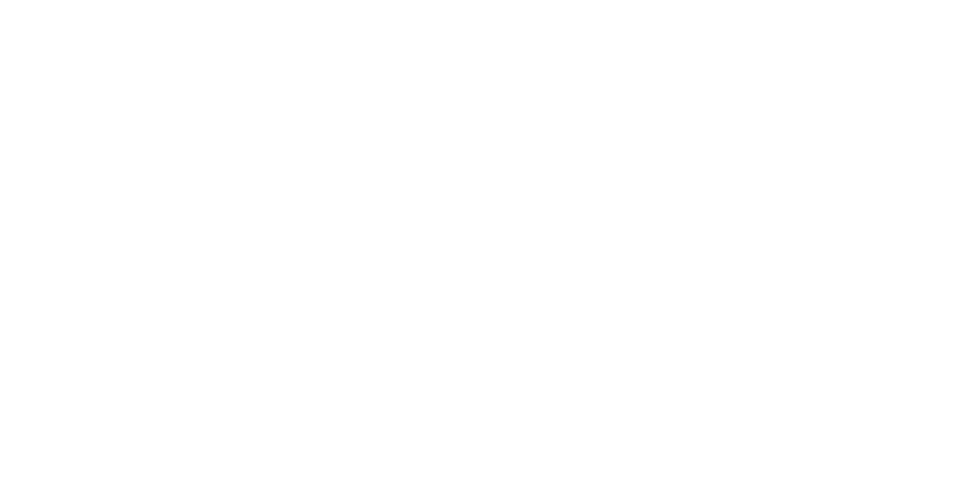

<IPython.core.display.Javascript object>


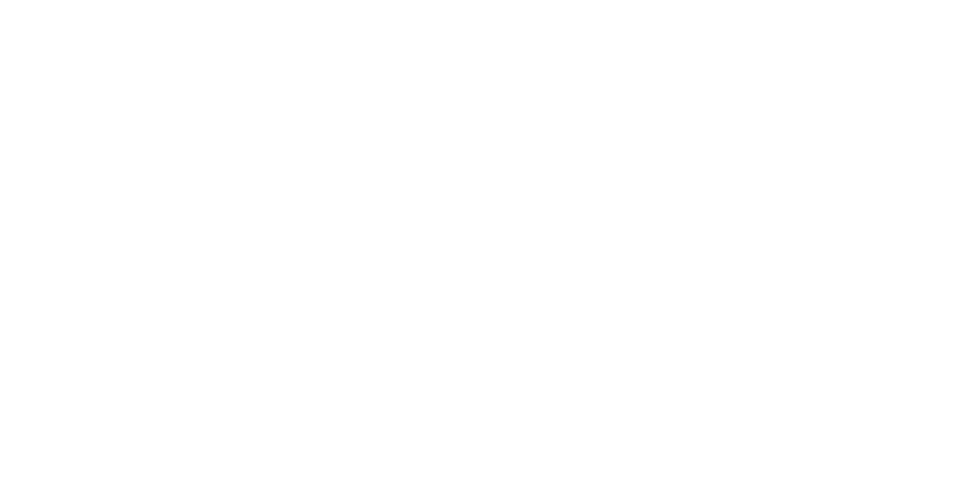

In [63]:
fig = plt.figure(figsize=(8,4), dpi=120)
ax = plt.subplot(121)
ax2 = plt.subplot(122)
for epoch in range(1,DOC2VEC_MAX_EPOCHS+1):
    try:
        model_name = placeholder_model_name.format(epoch)
        metrics = pickle.load(open(os.path.join(doc2vec_model_save_location, model_name, METRICS)))
        coverage_errors.append(coverage_error(metrics['y_true'], metrics['y_binary_score']))
        topN_avgs.append(metrics['topN_avg'])
        f1_micros.append(metrics['f1_micro'])
        precision_micros.append(metrics['precision_micro'])
        recall_micros.append(metrics['recall_micro'])
        f1_macros.append(metrics['f1_macro'])
        precision_macros.append(metrics['precision_macro'])
        recall_macros.append(metrics['recall_macro'])
        epochs.append(epoch)
        
        coverage_error_line, = ax.plot(epochs, coverage_errors, 'r-', label='Coverage Error')
        topN_avg_line, = ax.plot(epochs, topN_avgs, 'b-', label='Top N Avg')
        ax.legend(handles=[coverage_error_line, topN_avg_line])
        ax.xlabel("Epochs")
        ax.axis([1,epoch, 0, 10])

        f1_micro_line, = plt.plot(epochs, f1_micros, 'g-', label='F1 Micro')
        precision_micro_line, = plt.plot(epochs, precision_micros, 'r-', label='Precision Micro')
        recall_micro_line, = plt.plot(epochs, recall_micros, 'b-', label='Recall Micro')
        f1_macro_line, = plt.plot(epochs, f1_macros, 'g--', label='F1 Macro')
        precision_macro_line, = plt.plot(epochs, precision_macros, 'r--', label='Precision Macro')
        recall_macro_line, = plt.plot(epochs, recall_macros, 'b--', label='Recall Macro')
        plt.legend(handles=[f1_micro_line, precision_micro_line, recall_micro_line, f1_macro_line, precision_macro_line, recall_macro_line])
        plt.xlabel("Epochs")
        plt.axis([1,epoch, 0, 1])
        fig.canvas.draw()
        time.sleep(1)
    except Exception:
        break


[1, 50, 0, 1]

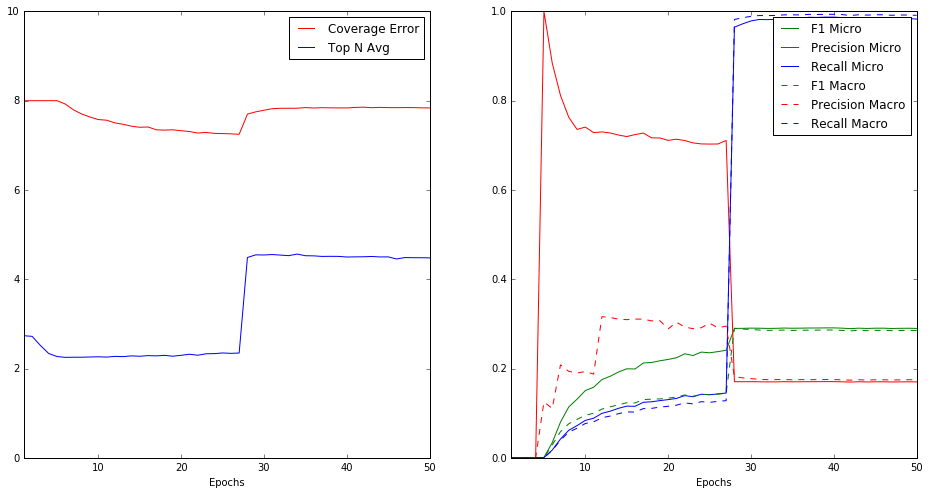

In [27]:
%matplotlib inline
coverage_errors = []
topN_avgs = []
f1_micros =  []
precision_micros = []
recall_micros = []
f1_macros =  []
precision_macros = []
recall_macros = []
epochs = []
for epoch in range(1,DOC2VEC_MAX_EPOCHS+1):
    try:
        model_name = placeholder_model_name.format(epoch)
        metrics = pickle.load(open(os.path.join(doc2vec_model_save_location, model_name, METRICS)))
        coverage_errors.append(coverage_error(metrics['y_true'], metrics['y_binary_score']))
        topN_avgs.append(metrics['topN_avg'])
        f1_micros.append(metrics['f1_micro'])
        precision_micros.append(metrics['precision_micro'])
        recall_micros.append(metrics['recall_micro'])
        f1_macros.append(metrics['f1_macro'])
        precision_macros.append(metrics['precision_macro'])
        recall_macros.append(metrics['recall_macro'])
        epochs.append(epoch)
    except Exception:
        break
fig = plt.figure(figsize=(16,8), dpi=120)
plt.subplot(121)
coverage_error_line, = plt.plot(epochs, coverage_errors, 'r-', label='Coverage Error')
topN_avg_line, = plt.plot(epochs, topN_avgs, 'b-', label='Top N Avg')
plt.legend(handles=[coverage_error_line, topN_avg_line])
plt.xlabel("Epochs")
plt.axis([1,epoch, 0, 10])

plt.subplot(122)
f1_micro_line, = plt.plot(epochs, f1_micros, 'g-', label='F1 Micro')
precision_micro_line, = plt.plot(epochs, precision_micros, 'r-', label='Precision Micro')
recall_micro_line, = plt.plot(epochs, recall_micros, 'b-', label='Recall Micro')
f1_macro_line, = plt.plot(epochs, f1_macros, 'g--', label='F1 Macro')
precision_macro_line, = plt.plot(epochs, precision_macros, 'r--', label='Precision Macro')
recall_macro_line, = plt.plot(epochs, recall_macros, 'b--', label='Recall Macro')
plt.legend(handles=[f1_micro_line, precision_micro_line, recall_micro_line, f1_macro_line, precision_macro_line, recall_macro_line])
plt.xlabel("Epochs")
plt.axis([1,epoch, 0, 1])

In [90]:
validation_vectors_matrix.shape

(5457, 1000)

In [152]:
print "lskdjf"

lskdjf


In [79]:
doc2vec_model.alpha

0.024

In [55]:
np.sum(np.sum(epoch_metrics[4]['y_binary_score']))

1

In [57]:
epoch_metrics[4]['precision_micro']

1.0

In [62]:
met = epoch_metrics[4]
coverage_error(met['y_true'], met['y_binary_score'])

8.0

In [60]:
[metric['total_positive'] for metric in epoch_metrics]

[0,
 0,
 0,
 0,
 1,
 52,
 138,
 215,
 261,
 301,
 324,
 363,
 382,
 408,
 428,
 424,
 455,
 466,
 476,
 488]

In [61]:
[metric['coverage_error'] for metric in epoch_metrics]

[0.0,
 0.0,
 0.0,
 0.0,
 0.001015744032503809,
 0.061452513966480445,
 0.19502285424073135,
 0.33824276282376842,
 0.43067546978161503,
 0.49263585576434737,
 0.5444388014220416,
 0.60690705942102585,
 0.63839512442864399,
 0.68765871000507872,
 0.72574911122397157,
 0.71356018283392586,
 0.75723717623158959,
 0.79075672930421537,
 0.81259522600304723,
 0.83951244286439819]

In [48]:
[metric['precision_micro'] for metric in epoch_metrics]

[0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.88461538461538458,
 0.81159420289855078,
 0.76279069767441865,
 0.73563218390804597,
 0.74086378737541525,
 0.72839506172839508,
 0.73002754820936644,
 0.72774869109947649,
 0.72303921568627449,
 0.71962616822429903,
 0.72405660377358494,
 0.72747252747252744,
 0.71673819742489275,
 0.71638655462184875,
 0.71106557377049184]

In [59]:
[metric['recall_micro'] for metric in epoch_metrics]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0003756574004507889,
 0.017280240420736288,
 0.042073628850488355,
 0.061607813673929375,
 0.072126220886551462,
 0.083771600300525925,
 0.088655146506386173,
 0.099549211119459052,
 0.10443275732531931,
 0.11081893313298272,
 0.11570247933884298,
 0.11532682193839218,
 0.12434259954921112,
 0.12546957175056347,
 0.128099173553719,
 0.13035311795642374]

In [49]:
[metric['topN_avg'] for metric in epoch_metrics]

[2.7343829355002538,
 2.7206703910614527,
 2.517013712544439,
 2.3367191467750126,
 2.2691721686135096,
 2.249873031995937,
 2.2534281361097004,
 2.2529202640934485,
 2.2585068562722195,
 2.2630777044184867,
 2.2559674961909599,
 2.2717115286947691,
 2.26663280853225,
 2.2833925850685626,
 2.2747587607922806,
 2.2889791772473336,
 2.2833925850685626,
 2.2950736414423565,
 2.2757745048247839,
 2.2960893854748603]

In [87]:
epoch_metrics[2]

{'average_num_of_labels': 1.3519553072625698,
 'average_precision_macro': 0.62302616614963602,
 'average_precision_micro': 0.61208739711365046,
 'coverage_error': 3.6353478923311324,
 'f1_macro': 0.48459584410527123,
 'f1_micro': 0.56405990016638929,
 'f1_scores_array': [0.6084724005134788,
  0.4574162679425837,
  0.7073170731707318,
  0.3741007194244605,
  0.0,
  0.5020576131687242,
  0.629500580720093,
  0.5979020979020979],
 'precision_macro': 0.5861309895614768,
 'precision_micro': 0.63187325256290772,
 'precision_scores_array': [0.5895522388059702,
  0.6035353535353535,
  0.6157112526539278,
  0.8666666666666667,
  0.0,
  0.7134502923976608,
  0.6691358024691358,
  0.6309963099630996],
 'recall_macro': 0.45201123608467181,
 'recall_micro': 0.50939143501126971,
 'recall_scores_array': [0.6286472148541115,
  0.3682588597842835,
  0.830945558739255,
  0.23853211009174313,
  0.0,
  0.3873015873015873,
  0.5942982456140351,
  0.5681063122923588],
 'topN_avg': 2.3869984763839511,
 'topN

In [156]:
metrics

{'average_num_of_labels': 1.1684075499358622,
 'average_precision_macro': 0.5730254718709914,
 'average_precision_micro': 0.5730254718709914,
 'coverage_error': 0.0,
 'f1_macro': 0.0,
 'f1_micro': 0.0,
 'f1_scores_array': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'precision_macro': 0.0,
 'precision_micro': 0.0,
 'precision_scores_array': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'recall_macro': 0.0,
 'recall_micro': 0.0,
 'recall_scores_array': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'topN_avg': 1.1684075499358622,
 'topN_list': [0,
  0,
  8,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  8,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  8,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  8,
  0,
  0,
  8,
  8,
  0,
  0,
  0,
  0,
  0,
  8,
  0,
  0,
  8,
  0,
  8,
  0,
  0,
  0,
  0,
  8,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
 

In [117]:
model.reset_from(loaded_model)

2016-08-16 15:49:28,921 : INFO : using concatenative 6800-dimensional layer1
using concatenative 6800-dimensional layer1
2016-08-16 15:49:28,925 : INFO : resetting layer weights
resetting layer weights


#### Now for the actual training

In [ ]:
%%time
model.build_vocab(sentences=LabeledLineSentence(training_file), progress_per=REPORT_VOCAB_PROGRESS)

2016-08-21 05:36:43,143 : INFO : collecting all words and their counts
2016-08-21 05:36:43,576 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
